In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.utils import shuffle 

from math import ceil,floor
import os
import cv2

import logging
logging.basicConfig(filename='log.txt',level=logging.DEBUG,format='%(asctime)s %(name)s - %(levelname)-s: %(message)s')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from CNN_require import *

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16083514231930950581
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10911298356
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2245381584707238467
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1"
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7658023450897115414
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10911298356
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18056452195419579859
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1"
]
0:Pass:16536 times:1
1:Missing:5068 times:3
2:MissAlignment:167 times:99
3:Tombstone_SideStanding:81 times:204
4:PartsReversed:224 times:73
5:ExcessComponent:362 times:45
6:Other_Damage:346 times:47
7:VoidSolder_Short:518 times:31
8:TextMissing:3006 times:5
9:tag:

In [3]:
model_name = saved_model.split('_')[0]+'_'+saved_model.split('_')[1]
print(f"model_name: {model_name}")
model = load_model(os.path.join('saved_models',"VGG16-Fine-Tune_datav6_0.8870_cropimg.h5"))
# model.summary()

model_name: VGG16-Fine-Tune_datav6


In [4]:
# import cv2
from sklearn.model_selection import train_test_split
""" Split the list into training set and validation set """
img_label_one_hot = pd.get_dummies(img_labels,'').as_matrix()
# print(img_label_one_hot)
print(img_label_one_hot.shape)

(161295, 10)


In [5]:
train_img_paths, valid_img_paths, y_train, y_valid = train_test_split(img_paths, img_label_one_hot, test_size=test_size,shuffle = True)

In [6]:
train_gen = AOI_train_batch_generator(train_img_paths,y_train,batch_size,img_size)
valid_gen = AOI_train_batch_generator(valid_img_paths,y_valid,batch_size,img_size)

In [7]:
validation_steps=ceil(len(valid_img_paths)/(batch_size*epochs))
steps_per_epoch = ceil(len(train_img_paths)/(batch_size*epochs))
print(f"val steps: {validation_steps}/val size: {len(valid_img_paths)}\ntrain step: {steps_per_epoch}/train size: {len(train_img_paths)}\nbatch size: {batch_size}")

val steps: 26/val size: 40324
train step: 76/train size: 120971
batch size: 16


In [8]:
def check_create_folder(path):
    if not os.path.exists(path):
        print(f"{path}\n{os.path.dirname(path)}")
        os.makedirs(path)

In [9]:
optimizer = keras.optimizers.Adam(lr=10e-6)
saveDir = 'saved_models'
# model_path = f'saved_models/{model_name}_{val_loss}.h5'
check_create_folder(saveDir)
checkpoint = ModelCheckpoint('./{0}/{2}_{1}_cropimg.h5'.format(saveDir, '{val_acc:.4f}',model_name)
                             , monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model_history = model.fit_generator(train_gen,
                                    epochs = epochs,
                                    validation_data = valid_gen,
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch = steps_per_epoch,
                                    validation_steps = validation_steps)

Epoch 1/100

76/76 [==============================] - 52s 678ms/step - loss: 0.4498 - acc: 0.8553 - val_loss: 0.3411 - val_acc: 0.8894

Epoch 00001: val_loss improved from inf to 0.34114, saving model to ./saved_models/VGG16-Fine-Tune_datav6_0.8894_cropimg.h5
Epoch 2/100
76/76 [==============================] - 44s 576ms/step - loss: 0.4068 - acc: 0.8577 - val_loss: 0.3695 - val_acc: 0.8846

Epoch 00002: val_loss did not improve from 0.34114
Epoch 3/100
76/76 [==============================] - 43s 561ms/step - loss: 0.4354 - acc: 0.8561 - val_loss: 0.2920 - val_acc: 0.9014

Epoch 00003: val_loss improved from 0.34114 to 0.29199, saving model to ./saved_models/VGG16-Fine-Tune_datav6_0.9014_cropimg.h5
Epoch 4/100
60/76 [======================>.......] - ETA: 7s - loss: 0.4304 - acc: 0.8552

76/76 [==============================] - 42s 554ms/step - loss: 0.4266 - acc: 0.8561 - val_loss: 0.3054 - val_acc: 0.8966

Epoch 00004: val_loss did not improve from 0.29199
Epoch 5/100
75/76 [=======

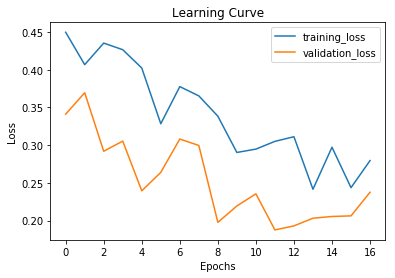

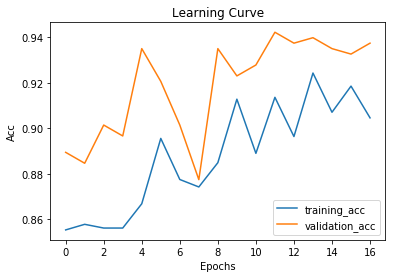

In [10]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

##### load test data

In [11]:
test_path = os.path.join(data_dir_path,'testset')
img_ID=[]
test_img_data_list=[]
test_img_class=[]
for img in sorted(os.listdir(test_path), key=str.lower):
    if img.endswith('.jpg'):
        test_img_class.append(get_class_id(img))
        x = img.split('.')
        img_ID.append(x[0])
        paths = test_path + '/' + img
        img = load_img(paths)
        img = np.array(img)
        test_img_data_list.append(img)
X_test = np.array(test_img_data_list)
print(X_test.shape)

(893, 224, 224, 3)


In [12]:
model = load_model(os.path.join('saved_models',saved_model))
model.summary()
logging.debug(f"model.summary():{model.summary()}")
print('model loading')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
imageTest = np.array(test_img_data_list)
imageTest = imageTest.astype('float32')
print(imageTest.shape)
logging.debug(f"imageTest.shape:{imageTest.shape}")

(893, 224, 224, 3)


In [14]:
from sklearn.metrics import accuracy_score

y_ans = model.predict(imageTest)
y_pred = y_ans.argmax(axis=-1)

y_true = np.array(test_img_class,dtype=int)

print(y_pred)
print(y_true)
logging.debug(f"y_pred:{y_pred}\ny_true:{y_true}")
accuracy_score(y_true, y_pred)

[1 1 8 8 8 8 0 0 6 6 8 8 8 0 8 0 1 6 8 8 8 8 8 8 1 1 1 5 8 8 1 6 8 8 6 6 0
 0 1 0 8 8 8 0 8 8 0 0 0 8 8 8 8 8 0 0 8 8 8 8 1 6 8 8 0 0 1 6 0 8 0 0 1 6
 8 8 1 0 8 8 1 1 8 0 8 8 8 8 8 8 8 0 6 6 8 8 7 6 8 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 9
 0 0 7 1 0 0 7 7 7 7 7 7 7 5 0 0 7 1 0 1 1 6 8 6 6 6 6 6 6 6 6 4 4 4 4 4 4
 4 0 0 0 0 0 0 0 0 0 1 1 1 1 5 0 1 1 5 3 3 3 3 1 5 1 1 8 8 8 8 1 1 1 1 0 0
 0 0 0 0 0 0 0 5 0 0 0 1 1 0 1 1 1 1 5 5 5 1 0 0 0 0 5 0 0 5 1 5 5 5 5 5 5
 0 0 0 0 0 0 0 5 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 5 5 0 0 0 0 0 0 0 0 0 0 8
 0 8 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 8 0 8 0 0 1 1 1 5 5 1 5 0 1 7 0 1 5
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 5 0 5 5 5 5 5 0 5 1 5 0 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

0.77267637178051507

In [15]:
from sklearn.metrics import accuracy_score

acc_s=accuracy_score(np.array(test_img_class,dtype=int), y_pred)
logging.debug(f"accuracy_score:{acc_s}")

In [16]:
from sklearn.metrics import confusion_matrix
conmatrix = confusion_matrix(np.array(test_img_class,dtype=int), y_pred,labels=range(len(target_labels)))
logging.debug(f"{conmatrix}")
conmatrix

array([[487,  47,   0,   1,   0,  50,   3,   2,   9,   0],
       [  0, 120,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   7,   0,   0,   0,   1,   0,   0,   4,   0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   7,   0,   0,   0,   0,   0],
       [ 10,   5,   0,   0,   0,   2,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   9,   0,   1,   0],
       [  7,   3,   0,   0,   0,   1,   0,   9,   0,   0],
       [ 22,  14,   0,   0,   0,   1,  12,   1,  50,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2]])

In [17]:
for i in range(len(target_labels)):
    x = conmatrix[i][i] / conmatrix.sum(axis= 1)[i] 
    print(target_labels[str(i)] + ": "+ str(x))
    logging.debug(f"{target_labels[str(i)]}:{str(x)}")

Pass: 0.813021702838
Missing: 1.0
MissAlignment: 0.0
Tombstone_SideStanding: 1.0
PartsReversed: 0.875
ExcessComponent: 0.117647058824
Other_Damage: 0.818181818182
VoidSolder_Short: 0.45
TextMissing: 0.5
tag: 1.0


In [18]:
for i in range(len(target_labels)):
    print(f"{target_labels[str(i)]}:{conmatrix.sum(axis= 1)[i]}")

Pass:599
Missing:120
MissAlignment:12
Tombstone_SideStanding:4
PartsReversed:8
ExcessComponent:17
Other_Damage:11
VoidSolder_Short:20
TextMissing:100
tag:2


## confusion_matrix

In [19]:
TP = conmatrix[0][0]
FP = conmatrix.sum(axis= 1)[0] - TP
FN = conmatrix.sum(axis= 0)[0] - TP
TN = len(y_pred) - conmatrix.sum(axis= 1)[0] - conmatrix.sum(axis= 0)[0] + TP
ACCURACY = (TP+TN)/len(y_pred)
PRECISION = TP/(TP+FP)
RECALL = TP/(TP+FN)
F1_SCORE = 2/(1/PRECISION + 1/RECALL)
print(f"ACCURACY: {ACCURACY:.4f}")
print(f"PRECISION: {PRECISION:.4f}")
print(f"RECALL: {RECALL:.4f}")
print(f"F1_SCORE: {F1_SCORE:.4f}")
logging.debug(f"ACCURACY:{ACCURACY}\nPRECISION:{PRECISION}\nRECALL:{RECALL}\nF1_SCORE:{F1_SCORE}")

ACCURACY: 0.8309
PRECISION: 0.8130
RECALL: 0.9259
F1_SCORE: 0.8658
